In [3]:
!pip install -r requirements.txt

  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached dotmap-1.3.23-py3-none-any.whl (10 kB)
  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached pandas-1.2.4-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Using cached tqdm-4.61.1-py2.py3-none-any.whl (75 kB)
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)
Processing /home/jovyan/.cache/pip/wheels/a0/18/0a/8ad18a597d8333a142c9789338a96a6208f1198d290ece356c/resampy-0.2.2-py3-none-any.whl
  Using cached pooch-1.4.0-py3-none-any.whl (51 kB)
Processing /home/jovyan/.cache/pip/wheels/ba/7b/eb/213741ccc0678f63e346ab8dff10495995ca3f426af87b8d88/audioread-2.1.9-py3-none-any.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstal

In [1]:
import os

In [2]:
import data_utils

In [3]:
import tensorflow as tf
import glob
import numpy as np
import json

In [4]:
from tqdm.auto import tqdm

In [5]:
import pickle

# Choose One folder and EnsambleMode
Mode types
* "mean of logits, then softmax"
* "softmax of logits, then mean"
* "sigmoid, then mean"
* "sigmoid, then median"
* "sigmoid, then geo mean"


In [6]:
# folder, EnsambleMODE = "MULTI_CLASS_VERSION/", "mean of logits, then softmax"
folder, EnsambleMODE = "MULTI_LABEL_VERSION/", "sigmoid, then median"

In [7]:
model_paths = sorted(glob.glob(folder+"/*.best_val.h5"))
model_paths

['MULTI_LABEL_VERSION/model.valid_00.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_01.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_02.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_03.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_04.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_05.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_06.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_07.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_08.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_09.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_10.best_val.h5',
 'MULTI_LABEL_VERSION/model.valid_11.best_val.h5']

In [8]:
config = json.load(open(folder+"/model_config.json",'r'))
config

{'depth': '5',
 'filters': '256',
 'global_kernel_size': '4',
 'use_dilate': 'True',
 'drop_rate': '0.3',
 'concat_mode': 'None',
 'gaussian_drop_rate': '0.05',
 'activation': '<function relu at 0x7fe79b795d40>',
 'final_group_mode': "['mean', 'max']"}

In [9]:
models = list(map(tf.keras.models.load_model, model_paths))

# Show ith_data

In [10]:
import IPython.display as idp

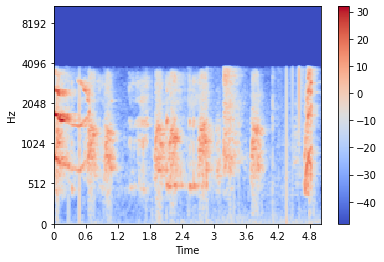

In [11]:
x, sr, label, remark = data_utils.load_wav("private_test/private_00017.wav")

data_utils.wav_to_mel(x, sr, display=True)

idp.Audio(x,rate=sr, autoplay=False)

# Create Private/Public Test Data

In [12]:
# private_wav_names = sorted(glob.glob("./private_test/*.wav"))
# public_wav_names = sorted(glob.glob("./public_test/*.wav"))

In [13]:
# def map_fun(path):
#   return data_utils.process(path)["mel"]

In [14]:
# %%time
# import multiprocessing
# pool_map = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# mels = pool_map.map(map_fun, public_wav_names)
# data = [*zip(public_wav_names, mels)]
# pickle.dump(data, open("public_test.pickle","wb"))

In [15]:
# %%time
# import multiprocessing
# pool_map = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# mels = pool_map.map(map_fun, private_wav_names)
# data = [*zip(private_wav_names, mels)]
# pickle.dump(data, open("private_test.pickle","wb"))

# Start Predict

In [16]:
public_test_from_pickle = pickle.load(open("public_test.pickle", "rb"))

In [17]:
private_test_from_pickle = pickle.load(open("private_test.pickle", "rb"))

In [18]:
PUBLIC_INPUTs = []
PUBLIC_INPUT_NAMES = []
PRIVATE_INPUTS = []
PRIVATE_INPUT_NAMES = []
for wav_name, mel in tqdm(public_test_from_pickle):
  PUBLIC_INPUTs.append(tf.transpose(mel))
  PUBLIC_INPUT_NAMES.append(wav_name)

for wav_name, mel in tqdm(private_test_from_pickle):
  PRIVATE_INPUTS.append(tf.transpose(mel))
  PRIVATE_INPUT_NAMES.append(wav_name)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [19]:
INPUT_TENSORS_PUBLIC = tf.stack(PUBLIC_INPUTs)
INPUT_TENSORS_PRIVATE = tf.stack(PRIVATE_INPUTS)

In [20]:
INPUT_TENSORS = tf.concat([INPUT_TENSORS_PUBLIC, INPUT_TENSORS_PRIVATE], axis=0)
all_names = PUBLIC_INPUT_NAMES+PRIVATE_INPUT_NAMES

In [21]:
ret = []
for m in tqdm(models):
  ret.append(m.predict(INPUT_TENSORS))

  0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
np.array(ret).shape

(12, 30000, 6)

In [23]:
if EnsambleMODE == "mean of logits, then softmax":
  probiblity = tf.math.softmax(tf.reduce_mean(tf.stack(ret), axis=0),axis=-1)
elif EnsambleMODE == "softmax of logits, then mean":
  probiblity = tf.reduce_mean(tf.math.softmax(tf.stack(ret), axis=-1), axis=0)
elif EnsambleMODE == "sigmoid, then mean":
  probiblity = tf.reduce_mean(tf.math.sigmoid(tf.stack(ret)), axis=0)
elif EnsambleMODE == "sigmoid, then median":
  probiblity = np.median(tf.math.sigmoid(tf.stack(ret)), axis=0)
elif EnsambleMODE == "sigmoid, then geo mean":
  probiblity = tf.reduce_prod(tf.math.sigmoid(tf.stack(ret)), axis=0)**(1/len(ret))
else:
  raise

EnsambleMODE

'sigmoid, then median'

In [24]:
probiblity.shape

(30000, 6)

In [25]:
import pandas as pd

In [26]:
df_prob_data = np.array(probiblity)

In [27]:
df_prob_data.shape

(30000, 6)

In [28]:
only_file_names = list(
  map(
    lambda string:string.split("/")[-1].split(".")[0],
    all_names,
  ),
)

In [29]:
only_file_names[:5]

['public_00001',
 'public_00002',
 'public_00003',
 'public_00004',
 'public_00005']

In [30]:
len(only_file_names)

30000

In [31]:
df_data = np.concatenate(
  [
    np.array(only_file_names).reshape(-1,1),
    df_prob_data
  ],axis=-1
)

In [32]:
df = pd.DataFrame(data=df_data, columns=['Filename', 'Barking', 'Howling', 'Crying', 'COSmoke', 'GlassBreaking','Other'])
df = df.sort_values(["Filename"])

In [33]:
df.head(20)

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
10000,private_00001,0.002246842,0.23889902,0.6218407,0.0073458347,0.015848268,0.0025005129
10001,private_00002,0.010965401,0.06469056,0.6742373,0.039295074,0.042494413,0.046973974
10002,private_00003,0.05830192,0.28054866,0.4549715,0.040136307,0.03708684,0.031411864
10003,private_00004,0.53274935,0.033670522,0.051702976,0.04906211,0.018565822,0.056560375
10004,private_00005,0.028320413,0.16242877,0.042461794,0.1954549,0.081719555,0.82891154
10005,private_00006,0.009095491,0.01967755,0.00948056,0.8555397,0.028369391,0.017343095
10006,private_00007,0.014808066,0.8070853,0.091189206,0.025392577,0.029683929,0.01359757
10007,private_00008,0.12330295,0.45525786,0.1429031,0.0035596155,0.0009552033,0.004519844
10008,private_00009,0.034089506,0.5969055,0.02311755,0.0015476889,0.0105036,0.0500556
10009,private_00010,0.2801053,0.34163344,0.082574055,0.032070056,0.019312683,0.100360185


In [34]:
folder

'MULTI_LABEL_VERSION/'

In [35]:
csv_path = folder+"/"+EnsambleMODE+"_privite_test.csv"
csv_path

'MULTI_LABEL_VERSION//sigmoid, then median_privite_test.csv'

In [36]:
df.to_csv(
  csv_path,
  index=False,
)